In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show, plot_events_data
from utils.optimization import MyOptimizationProblem, convert_to_model_params, plot_optimization_params, plot_optimization_error, plot_compare, compute_metrics, save_model_params_to_json, load_model_params_from_json
from utils.data import get_events, get_sections, load_df, process_df, export_dataframe_to_latex
from utils.sensitivity_analysis import describe_param_with_uniform_distribution, describe_param_with_log_uniform_distribution, describe_param_with_triangular_distribution, describe_param_with_normal_distribution, describe_param_with_truncated_normal_distribution, describe_param_with_log_normal_distribution, wrapped_model_function, create_problem_spec_and_sample, plot_sampled_distribuitions, evaluate_problem, analyze_time_step, analyze_problem, sobol_sensitivity_analysis_from_model_params_to_outputs, plot_sensitivity_analysis, plot_sensitivity_analysis_heatmaps, get_region_mean, plot_sensitivity_analysis_bars

import warnings
warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated/'
latex_tex_path = '/home/joaoantoniocardoso/workspace_TCC/repo/thesis/tex/generated/'

# Generation System model

In [2]:
from model import Generation

display(Generation.build({}))

<NonlinearIOSystem generation: ['pv_g', 'mppt_v_out', 'mppt_d'] -> ['mppt_i_out', 'mppt_i_in', 'mppt_v_in']>

In [3]:
generation_params = load_model_params_from_json('generation_params.json')
display(generation_params)

{'mppt_eta': 0.9323459474182263,
 'mppts_n': 4,
 'pv_S': 1.6367999999999998,
 'pv_eta': 0.14309907292684962}

## Sensitivity Analysis

In [4]:
def model_function(T, U, X0, **params):
    return ct.input_output_response(
        Generation.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
    ).to_pandas()

def generation_sensitivity_analysis_step_response(
    params_description: dict,
    poa_step: float,
    voltage_step: float,
    duty_cycle_step: float,
    samples: int,
    do_plot=True,
):

    model_class = Generation
    model_params = generation_params
    model_tmp = model_class.build(model_params)

    # Time array
    T = np.linspace(0, 10, 11, endpoint=True)

    # Initial state
    X0 = np.zeros(model_tmp.nstates)

    # Input data
    U = np.empty([model_tmp.ninputs, len(T)]) * np.nan # nan to force us to define every input
    U[model_tmp.input_labels.index('pv_g')] = poa_step
    U[model_tmp.input_labels.index('mppt_v_out')] = voltage_step
    U[model_tmp.input_labels.index('mppt_d')] = duty_cycle_step

    df_sa, problem = sobol_sensitivity_analysis_from_model_params_to_outputs(
        params_description=params_description,
        T=T,
        U=U,
        X0=X0,
        model_function=model_function,
        model_class=model_class,
        model_params=model_params,
        samples=samples,
        calc_second_order=True,
        seed=42,
        nprocs=32,
    )

    df_steady_state_mean = get_region_mean(df_sa, t_start=8, t_end=10)

    export_dataframe_to_latex(
        filename=f"{latex_tex_path}/generation_sensitivity_analysis.tex",
        label=f'table:generation_sensitivity_analysis',
        caption='Índices de Sobol em regime permanente',
        df_steady_state_mean=df_steady_state_mean,
    )

    if do_plot:
        display(df_steady_state_mean)

        # fig_save_and_show(
        #     None,
        #     'Distribuição dos valores para cada fator',
        #     'Distribution of the values for each factor',
        #     fig=plot_sampled_distribuitions(problem),
        #     ncols=3,
        # )

        # for output in df_sa['output'].unique():
        #     fig_save_and_show(
        #         None,
        #         f'Índices de Sobol para a saída {output} durante o tempo',
        #         f'Sobol Indices for the output {output} over time\nwith step of {poa_step} [W/m²] and {voltage_step} [V],\nwith {samples} samples',
        #         fig=plot_sensitivity_analysis(df_sa, output=output),
        #         ncols=3,
        #     )

        # for output in df_sa['output'].unique():
        #     fig_save_and_show(
        #         None,
        #         f'Índices de Sobol para a saída {output} durante o tempo',
        #         f'Sobol Indices for the output {output} over time\nwith step of {poa_step} [W/m²] and {voltage_step} [V],\nwith {samples} samples',
        #         fig=plot_sensitivity_analysis_heatmaps(df_sa, output=output),
        #         ncols=3,
        #     )

        for output in df_sa['output'].unique():
            fig_save_and_show(
                f'{latex_img_path}/generation_sensitivity_analysis_{output}.pdf',
                f'Índices de Sobol para a saída {output} em regime permanente',
                f'Sobol Indices for the output {output} at steady-state\nwith step of {poa_step} [W/m²] and {voltage_step} [V],\nwith {samples} samples',
                fig=plot_sensitivity_analysis_bars(df_steady_state_mean, output=output),
                ncols=3,
            )

    return df_sa, problem


In [5]:
# Estimating uncertainty of efficiency measurements. The equipment used was all fluke 115 (https://www.fluke.com/en/product/electrical-testing/digital-multimeters/fluke-115)
u_v_mppt = 0.5 / 100
u_i_mppt = 1 / 100

u_p_mppt = ((u_v_mppt)**2 + (u_i_mppt)**2)**0.5
u_eta_mppt = ((u_p_mppt)**2 + (u_p_mppt)**2)**0.5

# This is from here: https://www.nrel.gov/docs/fy09osti/45299.pdf
u_pv_area = 0.63/100
u_pv_eff = 3.9/100

print(u_eta_mppt, u_pv_area, u_pv_eff)

0.015811388300841896 0.0063 0.039


pool
chain


value          conf
output     factor             metric                            
mppt_i_in  pv_eta             S1      8.399416e-01  9.203971e-03
                              ST      8.400227e-01  6.613714e-03
           pv_S               S1      2.191800e-02  1.723075e-03
                              ST      2.193094e-02  2.429302e-04
           mppt_eta           S1      1.380575e-01  3.537279e-03
                              ST      1.381293e-01  1.287684e-03
           (pv_eta, mppt_eta) S2      6.999701e-05  1.230330e-02
           (pv_S, pv_eta)     S2      1.111232e-05  3.306577e-03
           (pv_S, mppt_eta)   S2      1.829140e-06  2.547467e-03
mppt_i_out pv_eta             S1      8.399416e-01  9.203971e-03
                              ST      8.400227e-01  6.613714e-03
           pv_S               S1      2.191800e-02  1.723075e-03
                              ST      2.193094e-02  2.429302e-04
           mppt_eta           S1      1.380575e-01  3.537279e-03
                              ST      1.381293e-01  1.287684e-03
           (pv_eta, mppt_eta) S2      6.999701e-05  1.230330e-02
           (pv_S, pv_eta)     S2      1.111232e-05  3.306577e-03
           (pv_S, mppt_eta)   S2      1.829140e-06  2.547467e-03
mppt_v_in  pv_eta             S1      4.822592e-17  1.149277e-16
                              ST      9.344838e-29  1.029047e-30
           pv_S               S1     -6.322646e-17  9.890584e-17
                              ST      9.017472e-29  1.114012e-30
           mppt_eta           S1      1.000000e+00  8.621605e-03
                              ST      1.000000e+00  7.269015e-03
           (pv_eta, mppt_eta) S2      0.000000e+00  1.554133e-15
           (pv_S, pv_eta)     S2      6.799123e-18  1.426367e-16
           (pv_S, mppt_eta)   S2      1.110223e-16  1.850373e-15

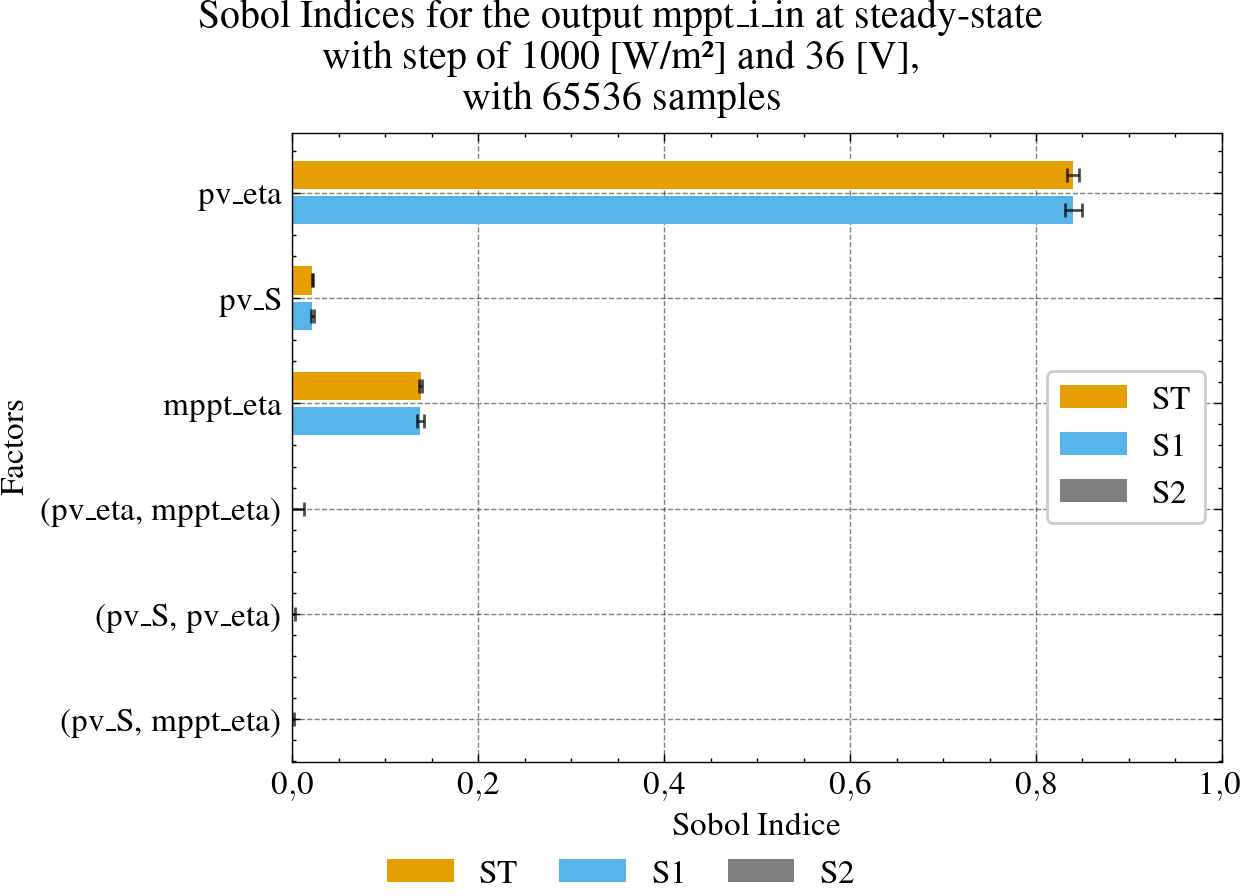

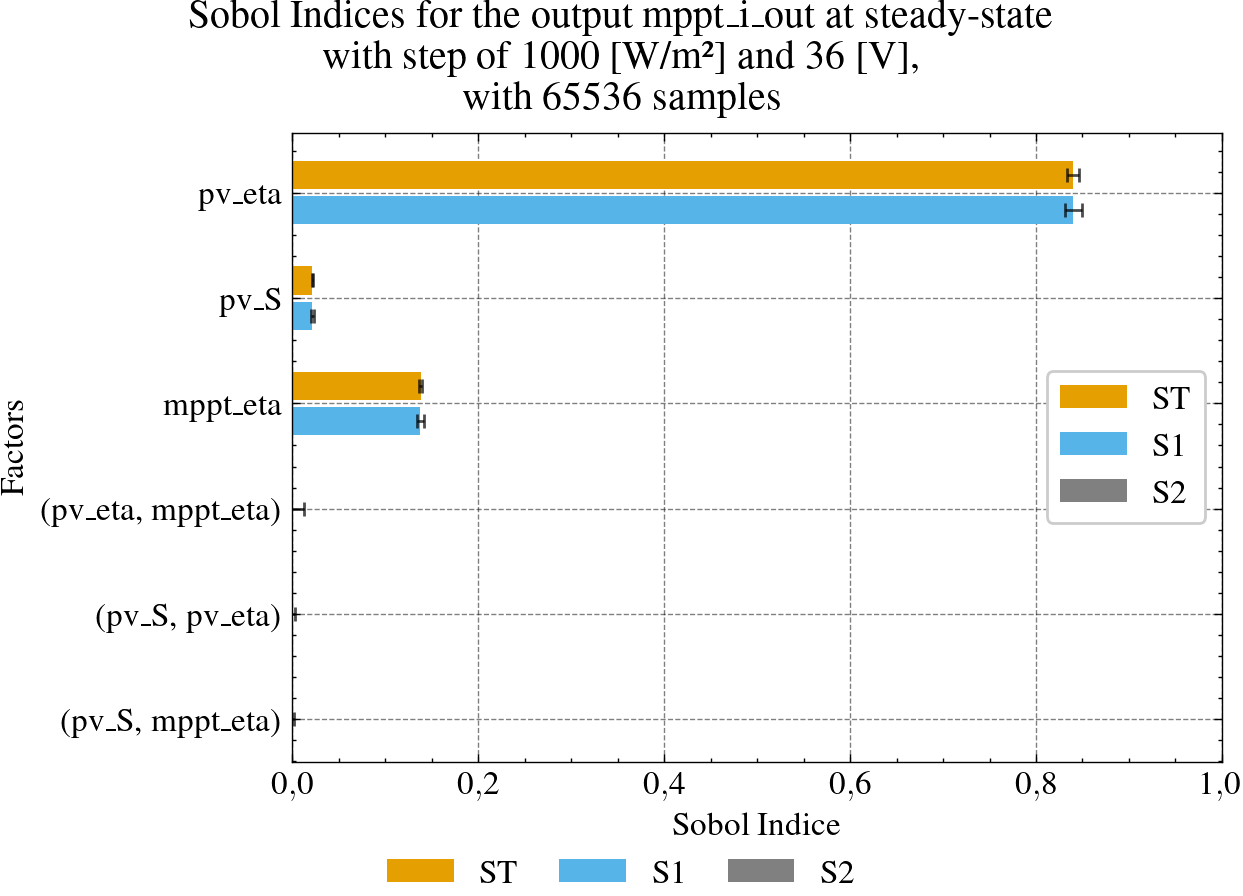

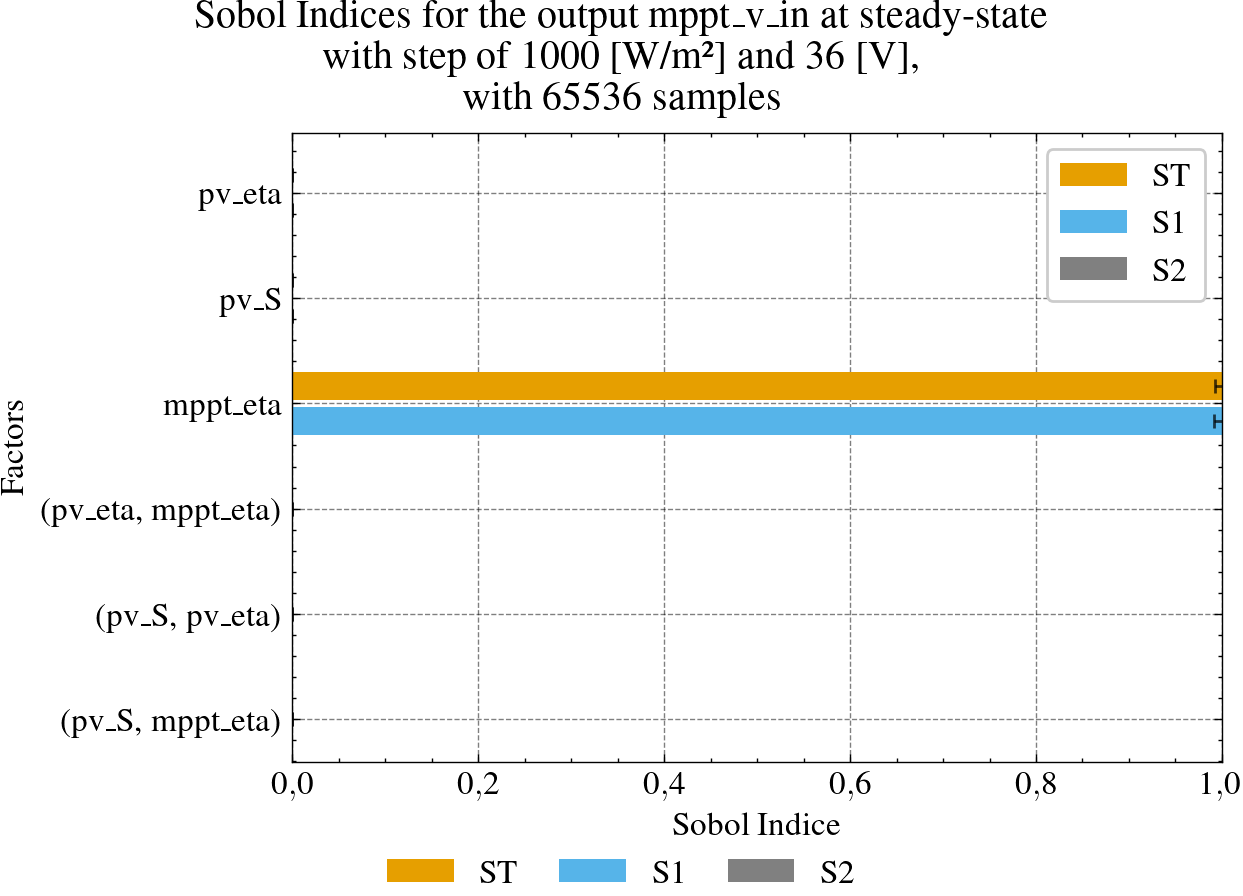

CPU times: user 2.69 s, sys: 4.01 s, total: 6.7 s
Wall time: 40.3 s


In [6]:
%%time

params_description = {
    'pv_S': describe_param_with_uniform_distribution(lower=generation_params['pv_S']*(1-u_pv_area), upper=generation_params['pv_S']*(1+u_pv_area)),
    'pv_eta': describe_param_with_uniform_distribution(lower=generation_params['pv_eta']*(1-u_pv_eff), upper=generation_params['pv_eta']*(1+u_pv_eff)),
    'mppt_eta': describe_param_with_uniform_distribution(lower=generation_params['mppt_eta']*(1-u_eta_mppt), upper=generation_params['mppt_eta']*(1+u_eta_mppt)),
}

df_sa, problem = generation_sensitivity_analysis_step_response(
    params_description=params_description,
    poa_step=1000,
    voltage_step=36,
    duty_cycle_step=0.6,
    samples=2**16,
    do_plot=True,
)


In [7]:
display(df_sa.head())

,output,factor,metric,t,value,conf
0,mppt_i_in,pv_eta,S1,0.0,0.839942,0.009204
1,mppt_i_in,pv_eta,S1,1.0,0.839942,0.009204
2,mppt_i_in,pv_eta,S1,2.0,0.839942,0.009204
3,mppt_i_in,pv_eta,S1,3.0,0.839942,0.009204
4,mppt_i_in,pv_eta,S1,4.0,0.839942,0.009204
